In [32]:
import os
import sys
import math

import numpy as np
from scipy.stats import norm
from scipy.interpolate import griddata

from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import catboost as cat
from catboost import CatBoostClassifier

from torch.utils.data import Dataset



def create_single_spiral(n_points, angle_offset, noise=0.1):
    # Create numbers in the range [0., 6 pi], where the initial square root maps the uniformly
    # distributed points to lie mainly towards the upper limit of the range
    n = np.sqrt(np.random.rand(n_points, 1)) * 3 * (2 * np.pi)

    # Calculate the x and y coordinates of the spiral and add random noise to each coordinate
    x = -np.cos(n + angle_offset) * n ** 2 + np.random.randn(n_points, 1) * noise * n * np.sqrt(n)
    y = np.sin(n + angle_offset) * n ** 2 + np.random.randn(n_points, 1) * noise * n * np.sqrt(n)

    return np.hstack((x, y))


def create_spirals(n_points, n_spirals=3, noise=0.1, seed=100):
    """
    Returns the three spirals dataset.
    """
    np.random.seed(seed)

    angle_separation = 2 * np.pi / n_spirals  # The angle separation between each spiral

    X, Y = [], []
    for i in range(n_spirals):
        X.append(create_single_spiral(n_points, angle_offset=angle_separation * i, noise=noise))
        Y.append(np.ones(n_points) * i)

    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    return np.asarray(X, dtype=np.float32), np.asarray(Y, dtype=np.long)


class SpiralDataset(Dataset):
    """ The Toy Three Class Dataset """

    def __init__(self, size, noise, scale, seed=100):
        self.scale = scale
        self.size = size
        self.noise = noise
        self.seed = seed


        self.x, self.y = create_spirals(n_points=size, n_spirals=3, noise=noise, seed=seed)
        return

    def __len__(self):
        return self.size * 3

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def plot(self, ax=None, s=10.0, alpha=0.7):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set(aspect='equal')
            colors = sns.color_palette()#(3, start=0.2, rot=-0.7, light=0.75)
            for i in range(3):
                plt.scatter(*np.hsplit(self.x[self.y == i], 2), color=colors[i], s=s, alpha=alpha)
        plt.ylim(-400,400)
        plt.xlim(-400,400)

        return ax


class Ensemble(object):
    
    def __init__(self, esize=10, iterations=1000, lr=0.1, random_strength=0, border_count=128, depth=6, seed=100):
        
        
        self.seed = seed
        self.esize=esize
        self.depth = depth
        self.iterations=iterations
        self.lr=lr
        self.random_strength = random_strength
        self.border_count = border_count
        self.ensemble = []
        for e in range(self.esize):
            model = CatBoostClassifier(iterations=self.iterations,
                           depth=self.depth,
                           learning_rate=self.lr,
                           border_count=self.border_count,
                           random_strength=self.random_strength,
                           loss_function='MultiClass',
                           verbose=False,
                           bootstrap_type='No',
                           posterior_sampling=True,
                           random_seed=self.seed+e)
            self.ensemble.append(model)
        
    def fit(self, data, eval_set = None):
        
        for m in self.ensemble:
            m.fit(data[0], y=data[1], eval_set=eval_data)
            print("best iter ", m.get_best_iteration())
            print("best score ", m.get_best_score())
            
    
    def predict(self,x):
        probs = []
        
        for m in self.ensemble:
            prob = m.predict_proba(x)
            probs.append(prob)
        probs = np.stack(probs)
        return probs
    
def get_grid(ext, resolution=200):
    x = np.linspace(-ext, ext, resolution, dtype=np.float32)
    y = np.linspace(-ext, ext, resolution, dtype=np.float32)
    xx, yy = np.meshgrid(x, y, sparse=False)
    return xx, yy

def kl_divergence(probs1, probs2, epsilon=1e-10):
    return np.sum(probs1 * (np.log(probs1 + epsilon) - np.log(probs2 + epsilon)), axis=1)



def entropy_of_expected(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)


def expected_entropy(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)

    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)


def mutual_information(probs, epsilon):
    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)
    return eoe - exe


def ensemble_uncertainties(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    conf = np.max(mean_probs, axis=1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)
    mutual_info = eoe - exe


    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                  }

    return uncertainty
    
    
def eval(ensemble, ext=15, resolution=200):
    xx, yy = get_grid(ext, resolution)
    inputs = np.stack((xx.ravel(), yy.ravel()), axis=1)
    #print(inputs)
    
    inputs_ext = np.array([make_new_coordinates(x,y) for x, y in np.stack((xx.ravel(), yy.ravel()), axis=1)])
    
    #print(inputs)
        

    probs = ens.predict(inputs_ext)

    unks = ensemble_uncertainties(probs)

    xi = np.linspace(-ext, ext, 1000)
    yi = np.linspace(-ext, ext, 1000)
    levels = 20

    zi_entropy = np.clip(griddata(inputs, unks['entropy_of_expected'], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
    zi_mutual_information = np.clip(griddata(inputs, unks['mutual_information'], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
    zi_data_uncertainty = np.clip(griddata(inputs, unks['expected_entropy'], (xi[None, :], yi[:, None]), method='cubic'), 0.0,
                                  None)

    # Print All figures
    
    # Total Uncertainty
    plt.contourf(xi, yi, zi_entropy, cmap=cm.Blues, alpha=0.9, levels=levels)
    plt.xlim(-ext, ext)
    plt.ylim(-ext, ext)
    plt.colorbar()
    #plt.savefig('total_uncertainty.png', bbox_inches='tight', dpi=500)
    plt.show()
    plt.close()
    
    # Data Uncertainty
    plt.contourf(xi, yi, zi_data_uncertainty, cmap=cm.Blues, alpha=0.9, levels=levels)
    plt.xlim(-ext, ext)
    plt.ylim(-ext, ext)
    plt.colorbar()
    plt.show()
    #plt.savefig('data_uncertainty.png', bbox_inches='tight', dpi=500, levels=levels)
    plt.close()


    # Knowledge Uncertainty
    plt.contourf(xi, yi, zi_mutual_information, cmap=cm.Blues, alpha=0.9, levels=levels)
    plt.xlim(-ext, ext)
    plt.ylim(-ext, ext)
    plt.colorbar()
    plt.show()
    plt.close()

def make_new_coordinates(x,y):
    return [x, y, x + y, x - y, 2*x + y, x - 2*y, x + 2*y, 2*x - y, math.sqrt(x*x + y*y)]

<AxesSubplot:>

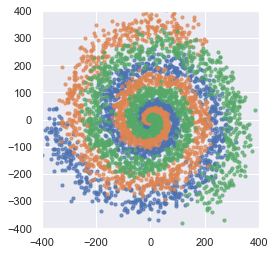

In [33]:
data = SpiralDataset(size=1500, scale=3, noise=0.4)
data.plot()

best iter  621
best score  {'learn': {'MultiClass': 0.18200194088964186}, 'validation': {'MultiClass': 0.33618999011109996}}
best iter  756
best score  {'learn': {'MultiClass': 0.18310237316596287}, 'validation': {'MultiClass': 0.3395488995211171}}
best iter  608
best score  {'learn': {'MultiClass': 0.18227121282842315}, 'validation': {'MultiClass': 0.3381999239996159}}
best iter  528
best score  {'learn': {'MultiClass': 0.1805661582162033}, 'validation': {'MultiClass': 0.3378110027891239}}
best iter  674
best score  {'learn': {'MultiClass': 0.18009153087550983}, 'validation': {'MultiClass': 0.3385115496255526}}
best iter  590
best score  {'learn': {'MultiClass': 0.1835137803081599}, 'validation': {'MultiClass': 0.33743288249571474}}
best iter  681
best score  {'learn': {'MultiClass': 0.1806117668582612}, 'validation': {'MultiClass': 0.33838094840867367}}
best iter  722
best score  {'learn': {'MultiClass': 0.18210506005239324}, 'validation': {'MultiClass': 0.33807634564883504}}
best it

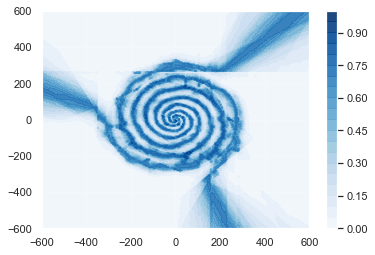

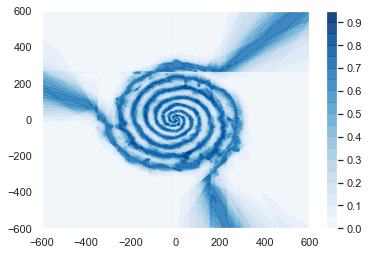

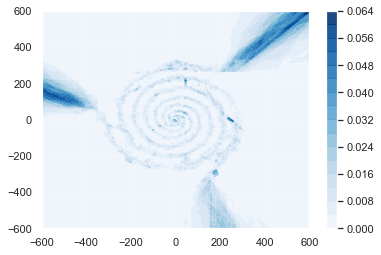

In [34]:
data = create_spirals(1500, noise=0.4, seed=24)
new_features = []
for i in range(len(data[0])):
    element = data[0][i]
    x = element[0]
    y = element[1]
    new_coordinates = make_new_coordinates(x,y)
    new_features.append(new_coordinates)
new_data = (np.array(new_features), data[1])
#print(new_data)

data = create_spirals(1500, noise=0.4, seed=51)
new_features = []
for i in range(len(data[0])):
    element = data[0][i]
    x = element[0]
    y = element[1]
    new_coordinates = make_new_coordinates(x,y)
    new_features.append(new_coordinates)
eval_data = (np.array(new_features), data[1])

ens = Ensemble(esize=20, iterations=1000, lr=0.1, depth=6, seed=2, random_strength = 100)
ens.fit(new_data, eval_set = eval_data)
eval(ens, ext=600, resolution=200)

## Evaluate Virtual Ensemble Uncertainty using internal Catboost functions

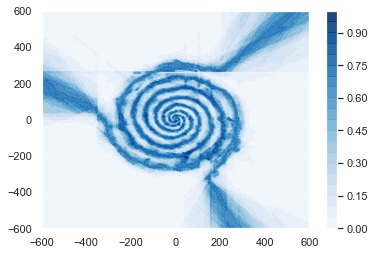

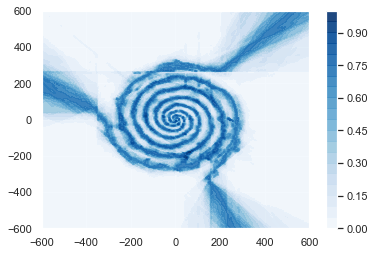

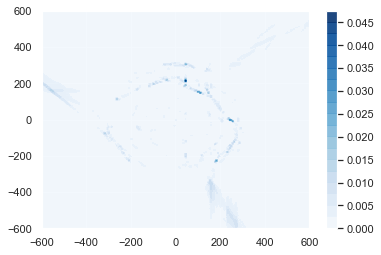

In [35]:
xx, yy = get_grid(600, 200)
ext=600
inputs = np.stack((xx.ravel(), yy.ravel()), axis=1)

inputs_ext = np.array([make_new_coordinates(x,y) for x, y in np.stack((xx.ravel(), yy.ravel()), axis=1)])

preds = ens.ensemble[1].virtual_ensembles_predict(inputs_ext, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

know = preds[:,1]-preds[:,0]

xi = np.linspace(-ext, ext, 1000)
yi = np.linspace(-ext, ext, 1000)
levels = 20

zi_entropy = np.clip(griddata(inputs, preds[:,0], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
zi_mutual_information = np.clip(griddata(inputs,  preds[:,1], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)


# Print All figures

# Total Uncertainty
plt.contourf(xi, yi, zi_entropy, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
#plt.savefig('total_uncertainty.png', bbox_inches='tight', dpi=500)
plt.show()
plt.close()

# Data Uncertainty
plt.contourf(xi, yi, zi_mutual_information, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
plt.show()
plt.close()

# Knowledge Uncertainty
zi_know = np.clip(griddata(inputs,  know, (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
plt.contourf(xi, yi, zi_know, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
plt.show()
plt.close()


## Evaluate Virtual Ensemble uncertainties manually

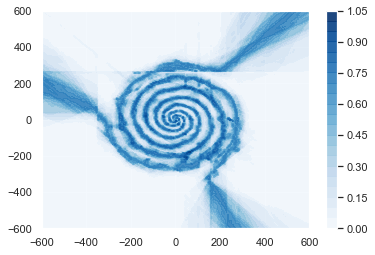

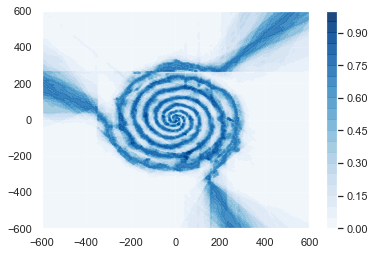

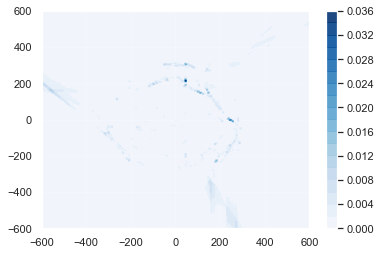

In [36]:
from scipy.special import softmax
xx, yy = get_grid(600, 200)
ext=600
inputs = np.stack((xx.ravel(), yy.ravel()), axis=1)
#print(inputs)

inputs_ext = np.array([make_new_coordinates(x,y) for x, y in np.stack((xx.ravel(), yy.ravel()), axis=1)])

preds = ens.ensemble[1].virtual_ensembles_predict(inputs_ext, prediction_type='VirtEnsembles', virtual_ensembles_count=100)
probs = softmax(preds,axis=2)

unks = ensemble_uncertainties(probs.transpose([1,0,2]))
xi = np.linspace(-ext, ext, 1000)
yi = np.linspace(-ext, ext, 1000)
levels = 20

zi_entropy = np.clip(griddata(inputs, unks['entropy_of_expected'], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
zi_mutual_information = np.clip(griddata(inputs, unks['mutual_information'], (xi[None, :], yi[:, None]), method='cubic'), 0.0, None)
zi_data_uncertainty = np.clip(griddata(inputs, unks['expected_entropy'], (xi[None, :], yi[:, None]), method='cubic'), 0.0,
                              None)

# Print All figures

# Total Uncertainty
plt.contourf(xi, yi, zi_entropy, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
#plt.savefig('total_uncertainty.png', bbox_inches='tight', dpi=500)
plt.show()
plt.close()

# Data Uncertainty
plt.contourf(xi, yi, zi_data_uncertainty, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
plt.show()
#plt.savefig('data_uncertainty.png', bbox_inches='tight', dpi=500, levels=levels)
plt.close()

# Knowledge Uncertainty
plt.contourf(xi, yi, zi_mutual_information, cmap=cm.Blues, alpha=0.9, levels=levels)
plt.xlim(-ext, ext)
plt.ylim(-ext, ext)
plt.colorbar()
plt.show()
plt.close()